#Import librairies:

In [ ]:
import pandas as pd
import numpy as np

from pprint import pprint
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

#Import Data:

#### Read CSV file:

In [ ]:
file = 'iris.csv'
df = pd.read_csv(file)

In [ ]:
df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


#### Data treatement:


###### Make class as hot vectors

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class_Iris-setosa,Class_Iris-versicolor,Class_Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


######Shuffle Data : 

In [ ]:
df = df.sample(frac=1)

In [ ]:
df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Class_Iris-setosa,Class_Iris-versicolor,Class_Iris-virginica
144,6.7,3.3,5.7,2.5,0,0,1
48,5.3,3.7,1.5,0.2,1,0,0
5,5.4,3.9,1.7,0.4,1,0,0
82,5.8,2.7,3.9,1.2,0,1,0
45,4.8,3.0,1.4,0.3,1,0,0
...,...,...,...,...,...,...,...
53,5.5,2.3,4.0,1.3,0,1,0
88,5.6,3.0,4.1,1.3,0,1,0
76,6.8,2.8,4.8,1.4,0,1,0
0,5.1,3.5,1.4,0.2,1,0,0


#####Separate dependent & non dependent variables:

In [ ]:
X = df.values[:,:4]
y = df.values[:,4:7]

In [ ]:
X[0]

array([0.97468354, 0.35443038, 0.84810127, 0.25316456])

##### Normalize Input Values :

In [ ]:
X = X/X.max()
X[0]

array([0.72151899, 0.37974684, 0.53164557, 0.15189873])

#####Split Train and Test data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Genetic Algorithm

In [ ]:
class GA:
  
  def __init__(self, classes=3, num_variables=4,
               crossover_rate= 0.5, mutation_rate=0.5,
               population_size= 100,
               epochs=10):
    np.random.seed(0)
    self.classes = 3
    self.num_variables = num_variables
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate
    self.population_size = population_size
    self.epochs = epochs

  #We create random chromosomes encoded as 12 value and 4 binary mask
  def create_population(self, n=None):
    if n is None:
      n = self.population_size
    population = []
    
    for _ in range(n):
      wts = np.random.random(self.num_variables*self.classes)
      mask = np.round(np.random.random(self.num_variables))
      gene = wts.tolist()+mask.tolist()
      population.append(gene)
    return population
  
  def pred_labels(self, chromosome, X):
    labels = []
    #size of weights
    split_pt = self.num_variables * self.classes
    #shape of weisghts
    wt_shape = (self.classes, self.num_variables)

    #reshape the population (:,4)
    wt, mask = (np.array(chromosome[:split_pt]).reshape(wt_shape),
                np.array(chromosome[split_pt:]).reshape(1, self.num_variables))
    #wt is a shape of (3,4) and mask (1,4), pt(1,4) is each line of training data
    #The idea is to compute the product of each wt which correspond to
    #vector of population with its mask and the vector of train data.
    #will sum the resulting vectors to get three vectors
    #then we'll take the index of the maximum of the vectors and assign it
    # to labels

    for pt in X:
      pt= np.array(pt)
      result = (wt * mask * pt)
      result = result.sum(axis=1)
      r=np.zeros(self.classes)
      r[result.argmax()] = 1
      labels.append(r)
    return labels


  def fitness(self, chromosome, X, y):
    #for each line of population we'll calculate the predicted
    #label, then calculate the score by substructing the prediction
    #and real value then subtruct it from two times lenth of data
    #and divide it from the double length since we have predicted and real
    #labels
    #for each line of y we calculate the score then we get a list of scores
      y_pred = self.pred_labels(chromosome, X)
      max_score = (2*len(X))
      score = (max_score-abs(y_pred - y).sum())/max_score
      return score

  def selection(self, population, score):
    score = np.array(score)
    prob = score/score.sum()
    #Selection will be made by roulette algorithm, the idea is to get
    #different index randomly based on the scores.
    
    #we have a population of size n, so we first take an list of (1..n)
    #to get indexes of the population.
    #and select randomly indexes, and more the probability more the index
    #will be picked.
    #now we'll select the population based of the indexes
    idx = np.random.choice(np.arange(self.population_size), self.population_size, True, prob)
    selected_population = [population[i] for i in idx]
    return selected_population

  def crossover(self, population, current_population, fitness_score):
    #sort the population according to the fitness:
    #we get the indexes of the fittest
    fittest_idx = np.array(fitness_score).argsort()
    #we sort population according to indexes of fittest:
    sorted_current_population = [current_population[i] for i in fittest_idx[::-1]]
    crossover_population = []

    pairs = np.random.randint(0, self.population_size,(self.population_size,2))
    #if random number is less than the crossover_rate, we pick randomly chromosomes the population
    for i, j in pairs:
      x= np.random.random()
      if x< self.crossover_rate:
        rand_indx = np.random.randint(0, self.classes*self.num_variables + self.num_variables)
        p1 = population[i]
        p2 = population[j]
        child = p1[:rand_indx] + p2[rand_indx:]
    #ELSE, we pick the fittest chromosome
      else:
        child = sorted_current_population.pop(0)
    
      crossover_population.append(child)
    return crossover_population
  
  def run_mutation(self, population):
    #since w've a num_var*num_classes value of pop and num_var of masks then:
    split_pt = self.num_variables * self.classes
    chromosome_len = len(population[0])

    mutated_pop = []
    for chromosome in population:
      if np.random.random() < self.mutation_rate:
        rand_indx_val = np.random.randint(0, split_pt)
        rand_indx_mask = np.random.randint(split_pt, chromosome_len)
        #we randomly change the value of a chromosome:
        chromosome[rand_indx_val] = np.random.random()
        #we split the mask value since it's binary:
        if chromosome[rand_indx_mask] == 1:
          chromosome[rand_indx_mask] = 0
        else :
          chromosome[rand_indx_mask] = 1
      mutated_pop.append(chromosome)
    return mutated_pop

  def ga_run(self, X, y):

    #we create the initial population based on the population size and the function defined before:
    pop = self.create_population()

    #we compute the fitness:
    fitness_score = [self.fitness(_, X, y) for _ in pop]
    
    best_fitness = 0
    best_solution = None
    current_population = pop.copy()
    
    for _ in range(self.epochs):
      selected_pop = self.selection(current_population, fitness_score)
      crossover_pop = self.crossover(pop, selected_pop, fitness_score)
      mutated_pop = self.run_mutation(crossover_pop)

      fitness_score = [self.fitness(_, X, y) for _ in mutated_pop]
      best_sol_idx = np.array(fitness_score).argmax()
      cur_best_solution = mutated_pop[best_sol_idx]
      cur_best_fitness = fitness_score[best_sol_idx]

      print(f'Best solution for generation <{_}>: {cur_best_fitness}')

      if cur_best_fitness > best_fitness:
        best_fitness = cur_best_fitness
        best_solution = cur_best_solution

      if best_fitness == 1:
        break
    print("*****************************************")
    print(f"***Best fitness : <{best_fitness}>***")
    return best_fitness, best_solution


Test:

In [ ]:
ga = GA(population_size=10, epochs=20, mutation_rate=0.5)
population_size = 10
pop = ga.create_population(population_size)
fitness_score = [ga.fitness(_, X_train, y_train) for _ in pop]
c_pop = pop.copy()
selected_pop = ga.selection(c_pop, fitness_score)
crossover = ga.crossover(pop, selected_pop, fitness_score)
mutation = ga.run_mutation(crossover)
best_fitness, best_solution = ga.ga_run(X_train, y_train)

Best solution for generation <0>: 0.3392857142857143
Best solution for generation <1>: 0.3392857142857143
Best solution for generation <2>: 0.3392857142857143
Best solution for generation <3>: 0.3392857142857143
Best solution for generation <4>: 0.3392857142857143
Best solution for generation <5>: 0.3392857142857143
Best solution for generation <6>: 0.3392857142857143
Best solution for generation <7>: 0.3392857142857143
Best solution for generation <8>: 0.3392857142857143
Best solution for generation <9>: 0.3392857142857143
Best solution for generation <10>: 0.3392857142857143
Best solution for generation <11>: 0.3392857142857143
Best solution for generation <12>: 0.3392857142857143
Best solution for generation <13>: 0.33035714285714285
Best solution for generation <14>: 0.3392857142857143
Best solution for generation <15>: 0.3392857142857143
Best solution for generation <16>: 0.3392857142857143
Best solution for generation <17>: 0.6696428571428571
Best solution for generation <18>: 0.

In [ ]:
predicted_labels = np.array(ga.pred_labels(best_solution, X_test)).argmax(axis=1)
predicted_labels

array([0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2])

In [ ]:
np.array(y_test).argmax(axis=1)

array([1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0,
       2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1])

#Application of the class GA:

In [ ]:
ga = GA(population_size=150, epochs= 150, mutation_rate= 0.4, crossover_rate= 0.6)

best_fitness, best_solution = ga.ga_run(X_train, y_train)

Best solution for generation <0>: 0.6696428571428571
Best solution for generation <1>: 0.6696428571428571
Best solution for generation <2>: 0.6071428571428571
Best solution for generation <3>: 0.6696428571428571
Best solution for generation <4>: 0.6696428571428571
Best solution for generation <5>: 0.6696428571428571
Best solution for generation <6>: 0.6428571428571429
Best solution for generation <7>: 0.6696428571428571
Best solution for generation <8>: 0.6696428571428571
Best solution for generation <9>: 0.6696428571428571
Best solution for generation <10>: 0.6696428571428571
Best solution for generation <11>: 0.7589285714285714
Best solution for generation <12>: 0.6785714285714286
Best solution for generation <13>: 0.6696428571428571
Best solution for generation <14>: 0.6696428571428571
Best solution for generation <15>: 0.6696428571428571
Best solution for generation <16>: 0.6696428571428571
Best solution for generation <17>: 0.6696428571428571
Best solution for generation <18>: 0.6

In [ ]:
pred = ga.pred_labels(best_solution, X_test)
predicted_labels = np.array(pred).argmax(axis=1)

#Confusion matrix:

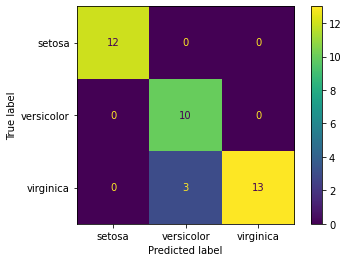

In [ ]:
o = ['setosa', 'versicolor', 'virginica']
cm = confusion_matrix(predicted_labels, np.array(y_test).argmax(axis=1))
ConfusionMatrixDisplay(cm, o).plot()

#ROC:

Text(0.5, 1.0, 'ROC curve')

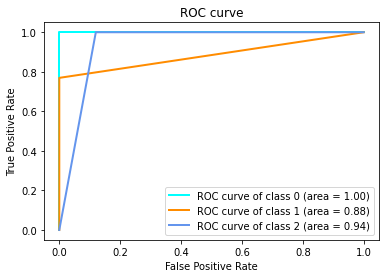

In [ ]:
n_classes=len(y_test[0])
lw=2
y_test = np.array(y_test)
pred = np.array(pred)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC curve")

#Precision Recall:

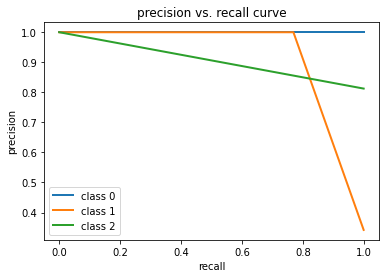

In [ ]:
# Compute Precision & Recall for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()